In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [61]:
# Load the data
data = pd.read_csv("customer_data_test.csv", sep=";", index_col=0)

In [62]:
# Display the first 5 rows of the data
data.head()

,ClientId,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
0,421818358,20,150.0,1524,1026,14.0,1,0.326772,0.485380,531.570730,...,38,1,163.162271,11.074390,0.083333,48,177,0.034146,0.180488,546035.164640
1,3969004,20,24.0,2861,1862,1589.0,79,0.349179,0.536520,9852.876319,...,50,3,4.631814,70.377688,0.335714,140,189,0.029126,0.077670,2324.851592
2,3914208,138,246.0,2931,1305,1745.0,1,0.554759,1.245977,4238.365290,...,264,4,11.845130,11.939057,0.200000,355,977,0.026281,0.074901,172054.092149
3,181640746,50,44.0,1828,1749,62.0,159,0.043217,0.045169,226.359711,...,231,2,197.958648,1.855407,0.000000,122,1184,0.007500,0.035000,27.571099
4,357038226,16,1.0,1185,1067,952.0,4,0.099578,0.110590,158.498777,...,33,5,3.262235,3.107819,0.352941,51,74,0.027027,0.081081,9.448649


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46063 entries, 0 to 51181
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ClientId               46063 non-null  int64  
 1   CountActiveBetDays     46063 non-null  int64  
 2   CountDepositDays       46063 non-null  float64
 3   LifeTime               46063 non-null  int64  
 4   TotalInactiveDays      46063 non-null  int64  
 5   TimeToFirstDeposit     46063 non-null  float64
 6   DaysSinceLastActivity  46063 non-null  int64  
 7   PercActiveDays         46063 non-null  float64
 8   ActivePassiveRatio     46063 non-null  float64
 9   TurnoverInEur          46063 non-null  float64
 10  TurnoverBonusInEur     46063 non-null  float64
 11  TurnoverLivePerc       46063 non-null  float64
 12  GGRInEur               46063 non-null  float64
 13  CompetitionCount       46063 non-null  int64  
 14  SportCount             46063 non-null  int64  
 15  AvBetOd

In [64]:
# Check for missing values
data.isnull().sum()

ClientId                 0
CountActiveBetDays       0
CountDepositDays         0
LifeTime                 0
TotalInactiveDays        0
TimeToFirstDeposit       0
DaysSinceLastActivity    0
PercActiveDays           0
ActivePassiveRatio       0
TurnoverInEur            0
TurnoverBonusInEur       0
TurnoverLivePerc         0
GGRInEur                 0
CompetitionCount         0
SportCount               0
AvBetOdd                 0
AvSportBetInEur          0
WinCoefficient           0
BetCount                 0
TeamCount                0
MaxTeamPercent           0
MaxCompetitionPercent    0
CasinoTurnoverInEur      0
dtype: int64

In [65]:
# Check for duplicates
data.duplicated().sum()

0

In [66]:
# Check for unique values
data.nunique()

ClientId                 46063
CountActiveBetDays         298
CountDepositDays           366
LifeTime                  2939
TotalInactiveDays         2878
TimeToFirstDeposit        3481
DaysSinceLastActivity      367
PercActiveDays           42315
ActivePassiveRatio       42315
TurnoverInEur            34856
TurnoverBonusInEur       21381
TurnoverLivePerc         22729
GGRInEur                 37696
CompetitionCount           637
SportCount                  20
AvBetOdd                 36819
AvSportBetInEur          34813
WinCoefficient            7291
BetCount                  1613
TeamCount                 2271
MaxTeamPercent            6542
MaxCompetitionPercent     9205
CasinoTurnoverInEur      44013
dtype: int64

In [67]:
# Describe the data
data.describe()

,ClientId,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
count,4.606300e+04,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,...,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,46063.000000,4.606300e+04
mean,4.000602e+08,21.551050,73.281527,1793.826108,1325.697458,483.250179,53.137051,0.257452,0.487500,763.911855,...,38.741007,1.796800,42.822813,14.323219,0.217199,95.097019,187.796257,0.280830,0.432284,3.400933e+04
std,6.693251e+08,41.620536,81.236750,836.402960,704.875801,814.069103,79.213785,0.199653,0.897947,2772.103677,...,82.766168,1.512256,104.108253,47.087480,0.281884,283.451528,436.277627,0.342842,0.341098,1.937638e+05
min,3.026400e+04,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-81.000000,0.000000,...,1.000000,1.000000,1.001000,0.000000,0.000000,1.000000,1.000000,0.002147,0.013434,0.000000e+00
25%,5.460858e+06,1.000000,6.000000,1147.000000,775.000000,0.000000,2.000000,0.094508,0.103276,1.174251,...,2.000000,1.000000,3.546000,0.286830,0.000000,1.000000,6.000000,0.042254,0.151515,2.082398e+02
50%,1.650696e+08,4.000000,43.000000,1849.000000,1279.000000,13.000000,12.000000,0.214528,0.270930,22.767000,...,7.000000,1.000000,8.992806,1.933240,0.111111,7.000000,26.000000,0.111111,0.307692,2.950424e+03
75%,5.143503e+08,18.000000,116.000000,2608.000000,1859.000000,722.000000,76.000000,0.378422,0.603960,301.067386,...,31.000000,2.000000,30.830425,7.028129,0.333333,47.000000,150.000000,0.333333,0.666667,1.854287e+04
max,4.292658e+09,334.000000,366.000000,2940.000000,2911.000000,5875.000000,366.000000,2.000000,20.375000,68711.204119,...,1037.000000,32.000000,1000.000000,1162.270125,1.000000,5842.000000,7035.000000,1.000000,1.000000,1.377935e+07


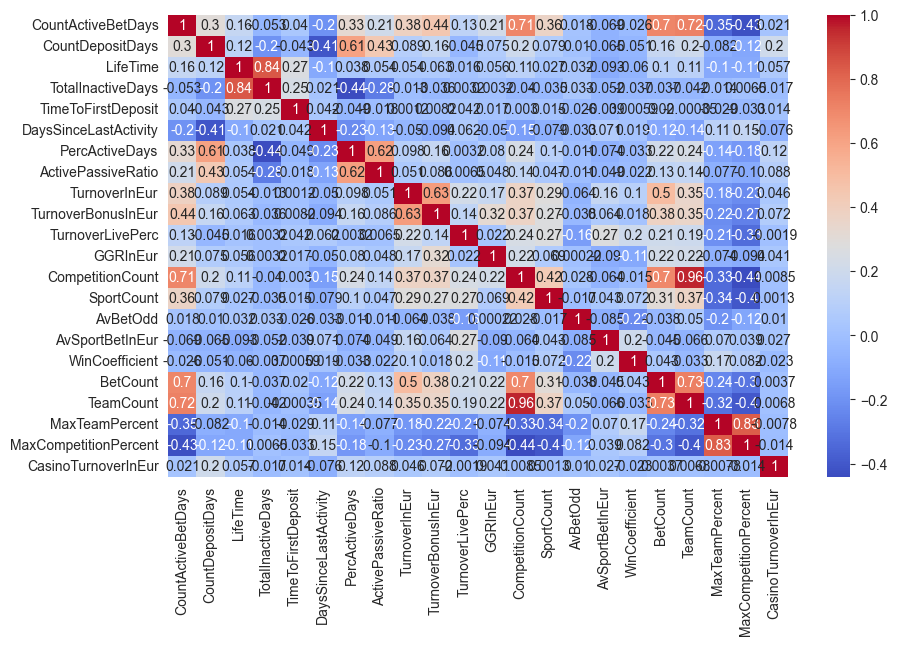

In [68]:
# Corelation matrix plot
correlation_mat = data.drop(columns=["ClientId"]).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_mat, annot=True, cmap="coolwarm")
plt.show()

In [69]:
correlation_mat

,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,TurnoverBonusInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
CountActiveBetDays,1.000000,0.300046,0.158073,-0.052717,0.039902,-0.199889,0.327565,0.209413,0.382743,0.443346,...,0.706616,0.363950,0.017879,-0.069160,-0.025953,0.703757,0.720634,-0.347348,-0.425689,0.020803
CountDepositDays,0.300046,1.000000,0.121150,-0.204227,-0.042833,-0.410174,0.609114,0.433139,0.088577,0.161064,...,0.198999,0.078637,0.010440,-0.065061,-0.051177,0.164058,0.199217,-0.081805,-0.116410,0.204927
LifeTime,0.158073,0.121150,1.000000,0.839519,0.266924,-0.103933,0.037719,0.054401,0.053623,0.062629,...,0.111957,0.027040,0.032142,-0.093365,-0.060023,0.103114,0.110144,-0.104817,-0.105969,0.056885
TotalInactiveDays,-0.052717,-0.204227,0.839519,1.000000,0.245410,0.020596,-0.441253,-0.281480,-0.012988,-0.035811,...,-0.039808,-0.034944,0.032517,-0.051617,-0.036839,-0.037182,-0.041996,-0.013562,0.006537,-0.017499
TimeToFirstDeposit,0.039902,-0.042833,0.266924,0.245410,1.000000,0.041599,-0.049452,-0.018065,0.001188,0.008237,...,0.002962,0.015461,-0.025848,-0.039098,0.000587,0.020448,-0.000354,-0.029483,-0.033139,0.013551
DaysSinceLastActivity,-0.199889,-0.410174,-0.103933,0.020596,0.041599,1.000000,-0.225449,-0.131410,-0.049664,-0.094172,...,-0.150545,-0.078651,-0.033115,0.070677,0.019097,-0.116697,-0.142720,0.114955,0.154247,-0.075697
PercActiveDays,0.327565,0.609114,0.037719,-0.441253,-0.049452,-0.225449,1.000000,0.620305,0.098371,0.160073,...,0.239242,0.100007,-0.011129,-0.074367,-0.032772,0.216079,0.239176,-0.142134,-0.176872,0.122634
ActivePassiveRatio,0.209413,0.433139,0.054401,-0.281480,-0.018065,-0.131410,0.620305,1.000000,0.050537,0.085959,...,0.142808,0.047073,-0.011064,-0.048589,-0.021836,0.133914,0.144481,-0.076956,-0.101811,0.088120
TurnoverInEur,0.382743,0.088577,0.053623,-0.012988,0.001188,-0.049664,0.098371,0.050537,1.000000,0.633630,...,0.370566,0.288779,-0.063825,0.158676,0.101436,0.499656,0.351801,-0.184394,-0.225411,0.045650
TurnoverBonusInEur,0.443346,0.161064,0.062629,-0.035811,0.008237,-0.094172,0.160073,0.085959,0.633630,1.000000,...,0.374932,0.271870,-0.038090,0.063664,0.017601,0.377793,0.354945,-0.219248,-0.265483,0.072478


In [70]:
# Get the most correlated features without duplicates
corr_pairs = correlation_mat.abs().unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
sorted_pairs = sorted_pairs[sorted_pairs != 1]
sorted_pairs = sorted_pairs[sorted_pairs > 0.5]
sorted_pairs = sorted_pairs[::2]
print(sorted_pairs)

CountDepositDays    PercActiveDays           0.609114
ActivePassiveRatio  PercActiveDays           0.620305
TurnoverBonusInEur  TurnoverInEur            0.633630
CompetitionCount    BetCount                 0.701176
BetCount            CountActiveBetDays       0.703757
CountActiveBetDays  CompetitionCount         0.706616
                    TeamCount                0.720634
TeamCount           BetCount                 0.728358
MaxTeamPercent      MaxCompetitionPercent    0.826882
LifeTime            TotalInactiveDays        0.839519
TeamCount           CompetitionCount         0.958317
dtype: float64


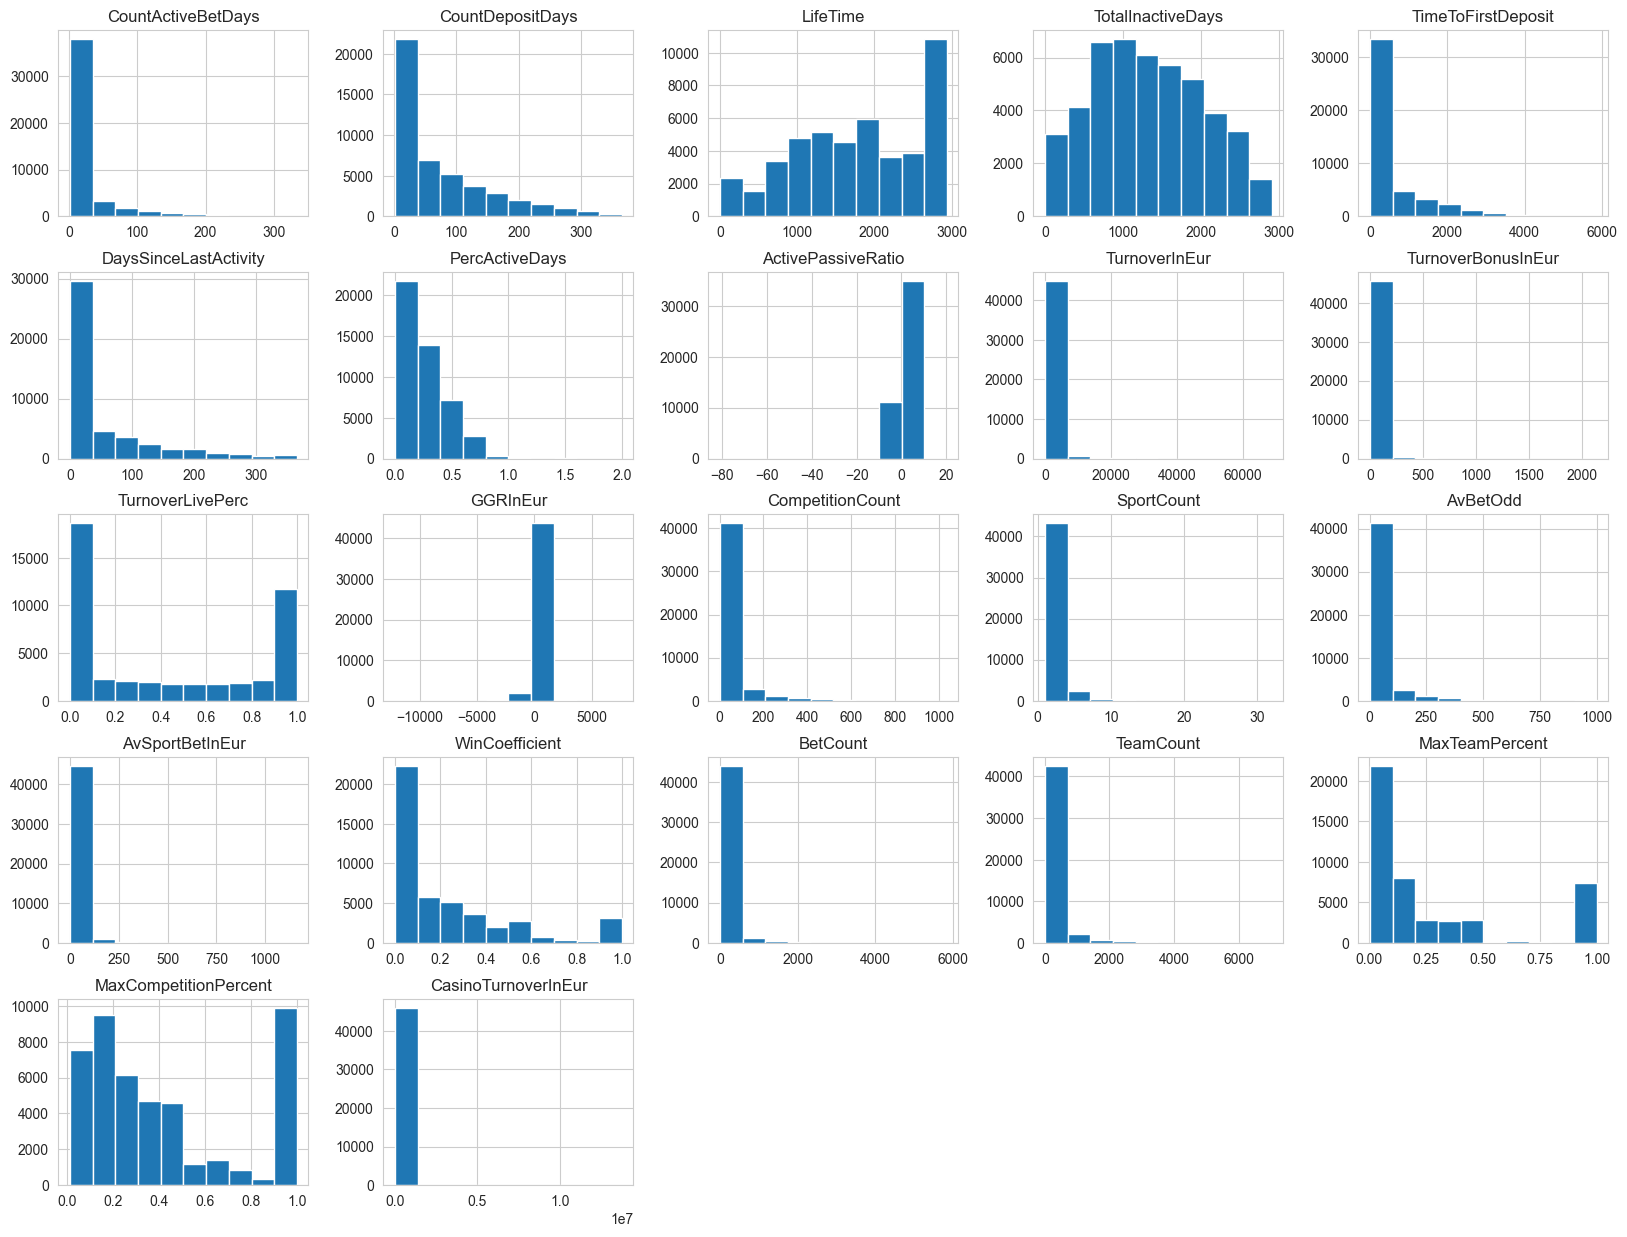

In [71]:
# Plot distribution of the features
data.drop(columns=["ClientId"]).hist(figsize=(20, 15))
plt.show()

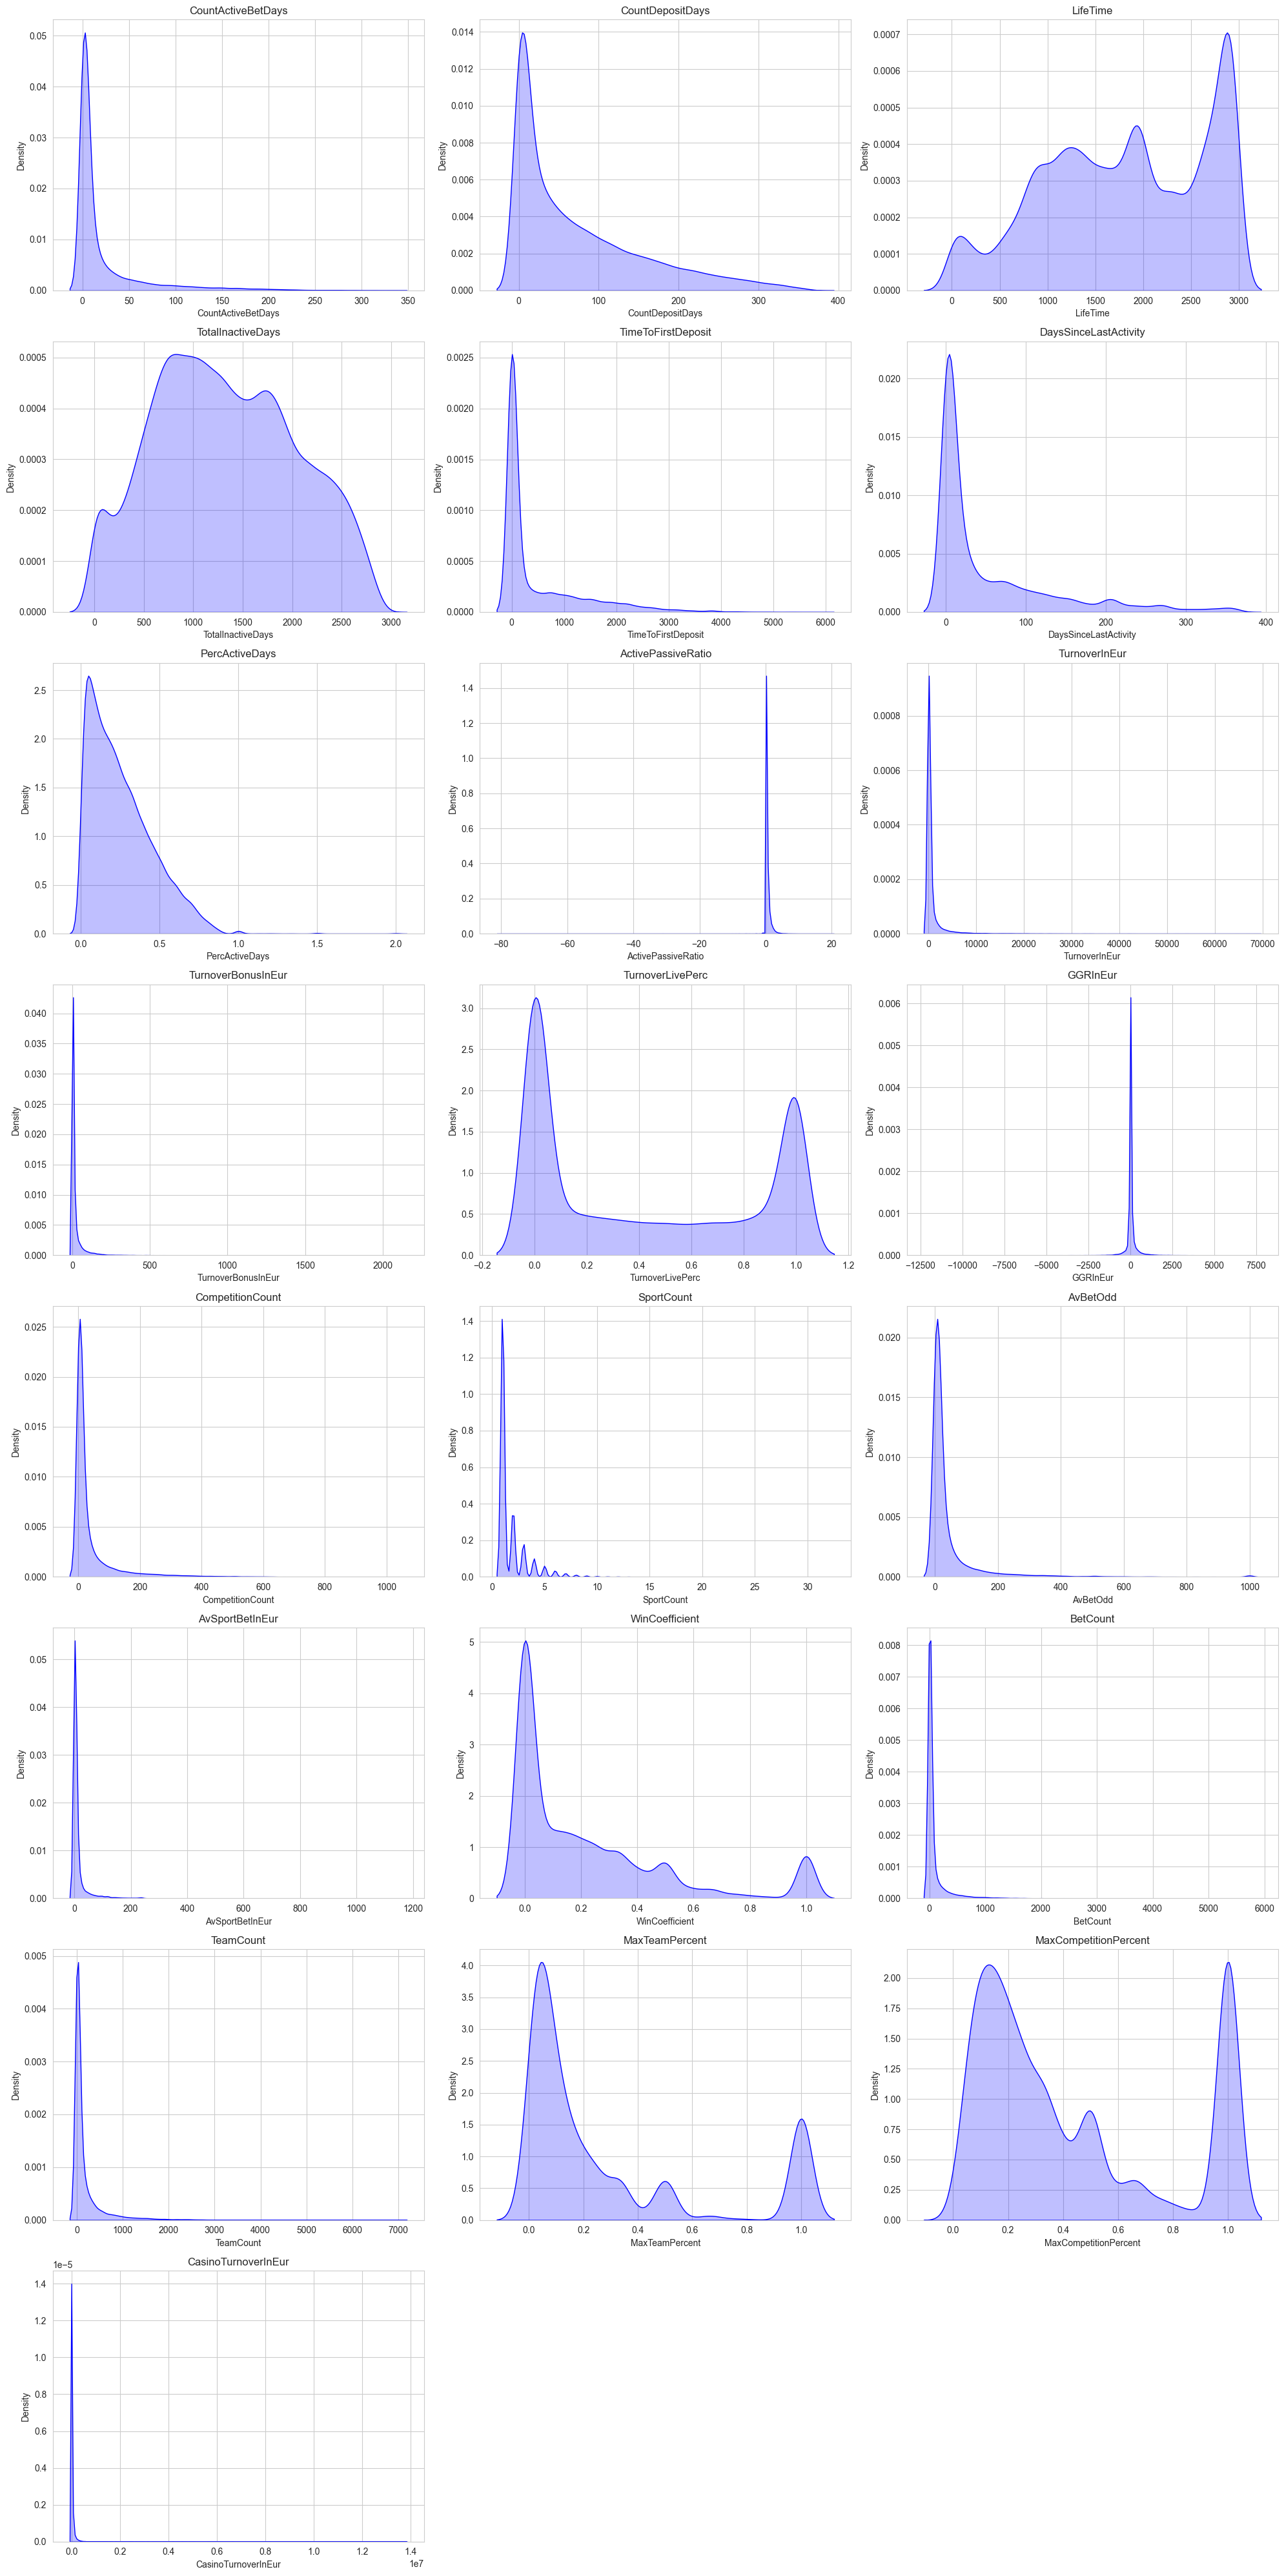

In [72]:
# Plot the distribution of the features using kdeplot
data_columns = data.columns.drop("ClientId")
num_features = len(data_columns)
num_cols = 3
num_rows = (
    num_features + num_cols - 1
) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(20, 5 * num_rows))
for i, column in enumerate(data_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.kdeplot(data[column], color="blue", fill=True)
    plt.title(column)

plt.tight_layout()
plt.show()

### Values of some features are negative and we should check them

In [73]:
# Get number of rows with negative values
negative_values = data[data < 0].count()
negative_values

ClientId                     0
CountActiveBetDays           0
CountDepositDays             0
LifeTime                     0
TotalInactiveDays          279
TimeToFirstDeposit           0
DaysSinceLastActivity        0
PercActiveDays               0
ActivePassiveRatio         279
TurnoverInEur                0
TurnoverBonusInEur           0
TurnoverLivePerc             0
GGRInEur                 13427
CompetitionCount             0
SportCount                   0
AvBetOdd                     0
AvSportBetInEur              0
WinCoefficient               0
BetCount                     0
TeamCount                    0
MaxTeamPercent               0
MaxCompetitionPercent        0
CasinoTurnoverInEur          0
dtype: int64

### There are 3 features with negative values:
- TotalInactiveDays
- ActivePassiveRatio
- GGRInEur

In [74]:
inactive_deys_less_then_zero = data[data["TotalInactiveDays"] < 0]
inactive_deys_less_then_zero

,ClientId,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
1872,2511112398,9,2.0,9,-1,244.0,189,1.111111,-10.0,2387.716842,...,45,1,3.041892,32.266444,0.486486,74,118,0.049180,0.065574,67.547867
12021,26891064,27,26.0,30,-1,107.0,1,1.033333,-31.0,119.745700,...,210,3,88.023178,0.473303,0.166008,253,1075,0.008415,0.036466,149.702594
12293,31168702,6,1.0,5,-1,5.0,123,1.200000,-6.0,118.751532,...,33,1,3.005376,1.276898,0.311828,93,105,0.037037,0.092593,0.091762
14630,153440202,5,8.0,8,-1,0.0,2,1.125000,-9.0,2.593051,...,33,1,48.291077,0.199465,0.153846,13,110,0.018182,0.072727,409.853751
16591,1845077838,1,1.0,0,-1,473.0,113,0.000000,-1.0,4.620580,...,1,1,3.199000,2.310290,0.000000,2,4,0.500000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46765,100839170,1,1.0,0,-1,1.0,61,0.000000,-1.0,712.086000,...,15,3,6.426167,118.681000,0.500000,6,36,0.055556,0.222222,343.425926
47492,2299021650,3,2.0,2,-1,472.0,12,1.500000,-3.0,1300.208637,...,16,2,2.657136,22.037435,0.372881,59,55,0.071429,0.142857,4.721406
47969,191322720,5,2.0,4,-1,1903.0,51,1.250000,-5.0,19.787904,...,18,1,20.995786,1.413422,0.357143,14,72,0.027778,0.166667,0.427367
48589,87293648,6,3.0,5,-1,70.0,1,1.200000,-6.0,1944.318646,...,19,1,17.647907,25.924249,0.213333,75,88,0.066667,0.283333,12920.593753


In [75]:
inactive_deys_less_then_zero["TotalInactiveDays"].value_counts()

TotalInactiveDays
-1    279
Name: count, dtype: int64

In [76]:
# Get the unique values of the difference between LifeTime and CountActiveBetDays
diff = inactive_deys_less_then_zero["LifeTime"] - inactive_deys_less_then_zero["CountActiveBetDays"]
diff.unique()

array([ 0,  3, -1,  2,  1,  4, 20, 18, 17, 79, 56])

In [77]:
diff.nunique()

11

In [78]:
# Get the unique values of the difference between LifeTime and CountActiveBetDays
diff.value_counts()

-1     254
 0      13
 3       3
 2       2
 1       1
 4       1
 20      1
 18      1
 17      1
 79      1
 56      1
Name: count, dtype: int64

### First of all, we need to calculate LefiTime because LifeTime cannot be greater than 365 

In [79]:
# Calculate LifeTime
data['LifeTime'] = data['LifeTime'].apply(lambda x: min(x, 365))

# Than calculate the difference between LifeTime and CountActiveBetDays
data["TotalInactiveDays"] = data["LifeTime"] - data["CountActiveBetDays"]

In [80]:
# Check for negative values
inactive_deys_less_then_zero = data[data["TotalInactiveDays"] < 0]
inactive_deys_less_then_zero

,ClientId,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
12293,31168702,6,1.0,5,-1,5.0,123,1.200000,-6.0,118.751532,...,33,1,3.005376,1.276898,0.311828,93,105,0.037037,0.092593,0.091762
16591,1845077838,1,1.0,0,-1,473.0,113,0.000000,-1.0,4.620580,...,1,1,3.199000,2.310290,0.000000,2,4,0.500000,1.000000,0.000000
16620,33000022,1,1.0,0,-1,0.0,130,0.000000,-1.0,0.000000,...,1,1,2.420000,0.000000,1.000000,1,2,1.000000,1.000000,44.875207
16740,114836718,1,1.0,0,-1,0.0,47,0.000000,-1.0,0.000000,...,1,1,4.002000,0.000000,1.000000,1,6,0.333333,1.000000,488.927032
16745,504412302,1,1.0,0,-1,1212.0,181,0.000000,-1.0,114.875500,...,1,1,1.770000,57.437750,0.000000,2,2,1.000000,1.000000,16.622443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46765,100839170,1,1.0,0,-1,1.0,61,0.000000,-1.0,712.086000,...,15,3,6.426167,118.681000,0.500000,6,36,0.055556,0.222222,343.425926
47492,2299021650,3,2.0,2,-1,472.0,12,1.500000,-3.0,1300.208637,...,16,2,2.657136,22.037435,0.372881,59,55,0.071429,0.142857,4.721406
47969,191322720,5,2.0,4,-1,1903.0,51,1.250000,-5.0,19.787904,...,18,1,20.995786,1.413422,0.357143,14,72,0.027778,0.166667,0.427367
48589,87293648,6,3.0,5,-1,70.0,1,1.200000,-6.0,1944.318646,...,19,1,17.647907,25.924249,0.213333,75,88,0.066667,0.283333,12920.593753


In [81]:
inactive_deys_less_then_zero["TotalInactiveDays"].value_counts()

TotalInactiveDays
-1    254
Name: count, dtype: int64

### We can conclude that:
- Not all of the values of the difference between LifeTime and CountActiveBetDays are negative
- We can find negative values when LifeTime is less than CountActiveBetDays in a case when we have N active days with intervals of N-1 days between them

### ActivePassiveRatio analysis

In [82]:
# Calculate ActivePassiveRatio
data["ActivePassiveRatio"] = data["CountActiveBetDays"] / data["TotalInactiveDays"]

In [83]:
active_passive_ratio_less_than_zero = data[data["ActivePassiveRatio"] < 0]
active_passive_ratio_less_than_zero

,ClientId,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
12293,31168702,6,1.0,5,-1,5.0,123,1.200000,-6.0,118.751532,...,33,1,3.005376,1.276898,0.311828,93,105,0.037037,0.092593,0.091762
16591,1845077838,1,1.0,0,-1,473.0,113,0.000000,-1.0,4.620580,...,1,1,3.199000,2.310290,0.000000,2,4,0.500000,1.000000,0.000000
16620,33000022,1,1.0,0,-1,0.0,130,0.000000,-1.0,0.000000,...,1,1,2.420000,0.000000,1.000000,1,2,1.000000,1.000000,44.875207
16740,114836718,1,1.0,0,-1,0.0,47,0.000000,-1.0,0.000000,...,1,1,4.002000,0.000000,1.000000,1,6,0.333333,1.000000,488.927032
16745,504412302,1,1.0,0,-1,1212.0,181,0.000000,-1.0,114.875500,...,1,1,1.770000,57.437750,0.000000,2,2,1.000000,1.000000,16.622443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46765,100839170,1,1.0,0,-1,1.0,61,0.000000,-1.0,712.086000,...,15,3,6.426167,118.681000,0.500000,6,36,0.055556,0.222222,343.425926
47492,2299021650,3,2.0,2,-1,472.0,12,1.500000,-3.0,1300.208637,...,16,2,2.657136,22.037435,0.372881,59,55,0.071429,0.142857,4.721406
47969,191322720,5,2.0,4,-1,1903.0,51,1.250000,-5.0,19.787904,...,18,1,20.995786,1.413422,0.357143,14,72,0.027778,0.166667,0.427367
48589,87293648,6,3.0,5,-1,70.0,1,1.200000,-6.0,1944.318646,...,19,1,17.647907,25.924249,0.213333,75,88,0.066667,0.283333,12920.593753


In [84]:
active_passive_ratio_less_than_zero.shape

(254, 23)

### 1

In [85]:
data[data["GGRInEur"] < 0]

,ClientId,CountActiveBetDays,CountDepositDays,LifeTime,TotalInactiveDays,TimeToFirstDeposit,DaysSinceLastActivity,PercActiveDays,ActivePassiveRatio,TurnoverInEur,...,CompetitionCount,SportCount,AvBetOdd,AvSportBetInEur,WinCoefficient,BetCount,TeamCount,MaxTeamPercent,MaxCompetitionPercent,CasinoTurnoverInEur
0,421818358,20,150.0,365,345,14.0,1,0.326772,0.057971,531.570730,...,38,1,163.162271,11.074390,0.083333,48,177,0.034146,0.180488,546035.164640
2,3914208,138,246.0,365,227,1745.0,1,0.554759,0.607930,4238.365290,...,264,4,11.845130,11.939057,0.200000,355,977,0.026281,0.074901,172054.092149
4,357038226,16,1.0,365,349,952.0,4,0.099578,0.045845,158.498777,...,33,5,3.262235,3.107819,0.352941,51,74,0.027027,0.081081,9.448649
18,4907828,28,89.0,365,337,720.0,1,0.126907,0.083086,1661.502723,...,32,1,107.494653,23.076427,0.152778,72,166,0.036697,0.238532,239566.253449
19,3877770,24,48.0,365,341,1878.0,3,0.260129,0.070381,776.972880,...,91,3,17.018552,8.093468,0.281250,96,290,0.042105,0.115789,7340.967658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51162,2894513232,20,172.0,365,345,0.0,1,0.489071,0.057971,4100.133383,...,28,8,8.056656,45.557038,0.377778,90,136,0.045977,0.183908,19915.222567
51164,170232476,6,1.0,365,359,0.0,217,0.031492,0.016713,13.833077,...,28,2,9.427700,1.383308,0.400000,10,98,0.020408,0.102041,12.021651
51168,190302364,15,73.0,365,350,53.0,2,0.621196,0.042857,20.826053,...,28,1,9.400000,0.433876,0.270833,48,165,0.044643,0.187500,20.810997
51172,269187044,82,8.0,365,283,2.0,1,0.303134,0.289753,37.920726,...,28,1,4.137477,0.354399,0.327103,107,146,0.076190,0.228571,143.750639
